<a href="https://colab.research.google.com/github/sonalisanjeevprabu18/Large-Language-Models/blob/main/LLM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


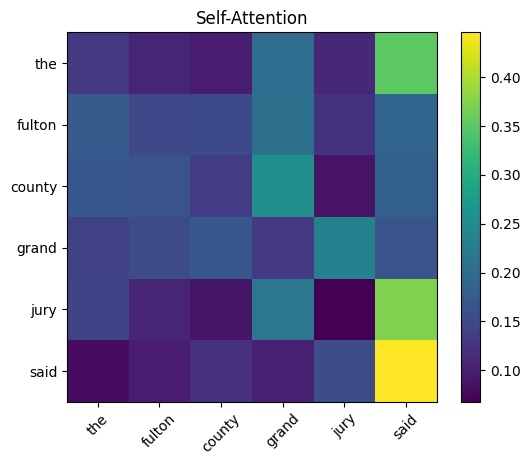

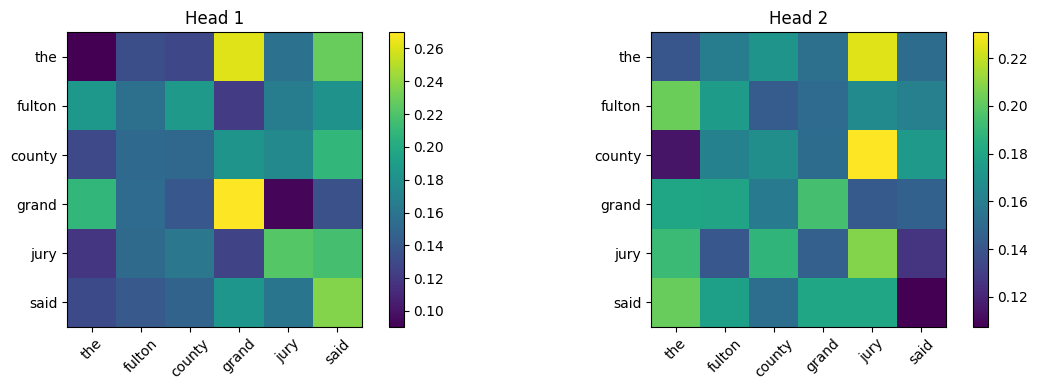

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import brown

nltk.download('brown')
torch.manual_seed(1)
# ---------------- DATA ----------------
tokens = [w.lower() for w in brown.words()[:6]]
vocab = {w: i for i, w in enumerate(set(tokens))}
indices = torch.tensor([[vocab[w] for w in tokens]])
embedding_dim = 8
x = nn.Embedding(len(vocab), embedding_dim)(indices)
# ---------------- SELF ATTENTION ----------------
class SelfAttention(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.WQ = nn.Linear(d, d)
        self.WK = nn.Linear(d, d)
        self.WV = nn.Linear(d, d)
        self.scale = d ** 0.5

    def forward(self, x):
        Q, K, V = self.WQ(x), self.WK(x), self.WV(x)
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        w = F.softmax(scores, dim=-1)
        return w @ V, w
# ---------------- MULTI-HEAD ATTENTION ----------------
class MultiHeadAttention(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        assert d % h == 0
        self.h = h
        self.dh = d // h
        self.WQ = nn.Linear(d, d)
        self.WK = nn.Linear(d, d)
        self.WV = nn.Linear(d, d)
        self.fc = nn.Linear(d, d)

    def forward(self, x):
        B, T, D = x.shape
        Q = self.WQ(x).view(B, T, self.h, self.dh).transpose(1, 2)
        K = self.WK(x).view(B, T, self.h, self.dh).transpose(1, 2)
        V = self.WV(x).view(B, T, self.h, self.dh).transpose(1, 2)

        scores = (Q @ K.transpose(-2, -1)) / (self.dh ** 0.5)
        w = F.softmax(scores, dim=-1)
        out = (w @ V).transpose(1, 2).contiguous().view(B, T, D)
        return self.fc(out), w
# ---------------- RUN SELF ATTENTION ----------------
sa = SelfAttention(embedding_dim)
_, sa_w = sa(x)

plt.imshow(sa_w[0].detach(), cmap="viridis")
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.title("Self-Attention")
plt.colorbar()
plt.show()

# ---------------- RUN MULTI-HEAD ATTENTION ----------------
mha = MultiHeadAttention(embedding_dim, 2)
_, mha_w = mha(x)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for h in range(2):
    im = axes[h].imshow(mha_w[0, h].detach(), cmap="viridis")
    axes[h].set_xticks(range(len(tokens)))
    axes[h].set_yticks(range(len(tokens)))
    axes[h].set_xticklabels(tokens, rotation=45)
    axes[h].set_yticklabels(tokens)
    axes[h].set_title(f"Head {h+1}")
    plt.colorbar(im, ax=axes[h], fraction=0.046)

plt.tight_layout()
plt.show()
